In [1]:
import os
import json
import cv2 as cv
import numpy as np
from matplotlib import cm, pyplot as plt
from IPython.display import display, Markdown

from imageutils import resize, mean_square_diff, NumpyEncoder

# For reproducible results
np.random.seed(0)

# Face Recognition

In [2]:
FACES_ROOT = "Color FERET Database"
FACE_IDS = os.listdir(FACES_ROOT)

def yield_face_images(face_id, scale_factor=1.0):
    " Read grayscale images for given face ID and scale them by the scaling factor "
    dirname = os.path.join(FACES_ROOT, face_id)
    assert os.path.isdir(dirname)
    for fn in os.listdir(dirname):
        yield resize(cv.imread(os.path.join(dirname, fn), cv.IMREAD_GRAYSCALE),
                     scale=scale_factor)

In [3]:
def random_partition(data, ratio):
    " Partition a list into two, such that the len(first)/len(second) ~ ratio "
    first = data.copy()
    second = []
    while len(first) > ratio * len(data):
        second.append(first.pop(np.random.randint(len(first))))
    return first, second

def load_and_partition_images(face_ids, train_ratio, scale):
    " Load images for each face and partition them into training and test sets "
    trainset = {}
    testset = {}
    for face_id in face_ids:
        images_for_id = list(yield_face_images(face_id, scale))
        shape = images_for_id[0].shape
        print("Face {2}: loaded {0} images of shape {1}:".format(len(images_for_id), shape, face_id), end = ' ')
        train_for_id, test_for_id = random_partition(images_for_id, train_ratio)
        print("{} for training set, {} for test set".format(len(train_for_id),
                                                            len(test_for_id)))
        trainset[face_id], testset[face_id] = train_for_id, test_for_id
    return trainset, testset


In [4]:
TRAIN_JSON = "trainset.json"
TEST_JSON = "test.json"

def restore_from_json():
    with open(TRAIN_JSON, 'r') as f:
        trainset = dict((key, [np.asarray(img) for img in value])
                        for key, value in json.load(f).items())
    with open(TEST_JSON, 'r') as f:
        testset = dict((key, [np.asarray(img) for img in value])
                       for key, value in json.load(f).items())
    return trainset, testset

def store_to_json(trainset, testset):
    with open(TRAIN_JSON, 'w') as f:
        json.dump(trainset, f, cls=NumpyEncoder)
    with open(TEST_JSON, 'w') as f:
        json.dump(testset, f, cls=NumpyEncoder)

# Restore training and test sets from disk, if available, to save time
RESTORE_FROM_JSON = False # set False to deactivate
if RESTORE_FROM_JSON and os.path.isfile(TRAIN_JSON) and os.path.isfile(TEST_JSON):
    trainset, testset = restore_from_json()

# Construct the training and test set
else:
    TRAIN_RATIO = 0.8
    SCALE = 1.0/16  # downscale images for performance
    trainset, testset = load_and_partition_images(FACE_IDS, TRAIN_RATIO, SCALE)
    store_to_json(trainset, testset)

# Get the shape of the images from the first image (assume all others are the same)
shape = next(iter(trainset.values()))[0].shape

In [16]:
# Combine all training set images into a matrix, X
trainset_all_images = [img for imgs in trainset.values() for img in imgs]

print("Building a column matrix of {} images:".format(len(trainset_all_images)))
X = np.vstack([img.ravel() for img in trainset_all_images]).T
print("X.shape", X.shape)

label = dict((tuple(img.ravel().tolist()), face_id)
             for face_id, imgs in trainset.items() for img in imgs)


Building a column matrix of 1603 images:
X.shape (1536, 1603)


## Principal Component Analysis

In [6]:
def PCA(M):
    """
    Use np.linalg.svd to perform Principal Component Analysis
    Credit: https://stackoverflow.com/a/12273032
    
    Singular value decomposition (SVD) factorizes your data matrix such that:

      M = U*S*V.T     (where '*' is matrix multiplication)

    * U and V are the singular matrices, containing orthogonal vectors of
      unit length in their rows and columns respectively.

    * S is a diagonal matrix containing the singular values of M - these 
      values squared divided by the number of observations will give the 
      variance explained by each PC.

    * if M is considered to be an (observations, features) matrix, the PCs
      themselves would correspond to the rows of S^(1/2)*V.T. if M is 
      (features, observations) then the PCs would be the columns of
      U*S^(1/2).

    * since U and V both contain orthonormal vectors, U*V.T is equivalent 
      to a whitened version of M.
    """
    u = M.mean(1)
    D = (M.transpose() - u).transpose()
    U, s, Vt = np.linalg.svd(D, full_matrices=False)
    return u, U, s, Vt

# Perform PCA
mean_face, U, s, Vt = PCA(X)
V = Vt.T
PC = np.dot(U, np.diag(s))

### Mean Face and Eigenfaces
Having determined the principal components (eigenfaces), we can now plot the mean face and the first 10 (actually 11) eigenfaces:

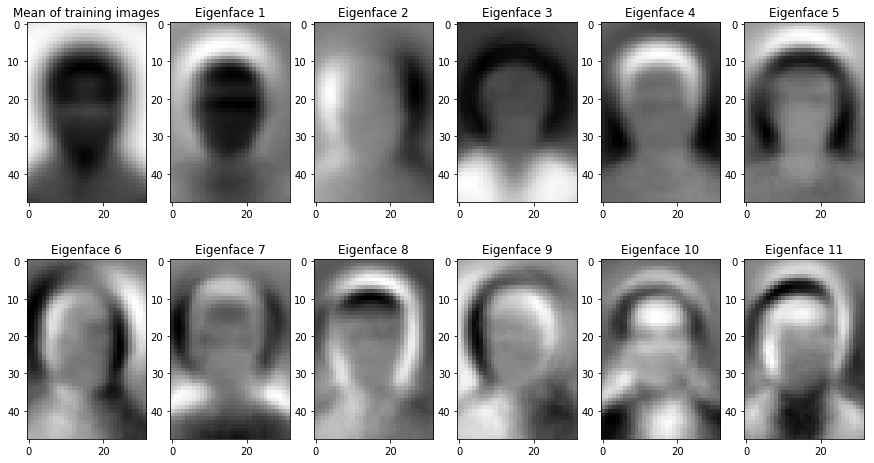

In [21]:
fig, subs = plt.subplots(2, 6, figsize=(15,8))
subs[0, 0].imshow(mean_face.reshape(shape), cmap=cm.gray)
subs[0, 0].set_title('Mean of training images')
for i, sub in enumerate(subs.ravel()[1:]):
    #sub.imshow((S[0,0]**(1./2) * V[:,0]).reshape(img.shape), cmap=cm.gray)    
    #sub.imshow((U[:,i] * (s[i]**(1./2))).reshape(shape), cmap=cm.gray)
    sub.imshow(PC[:,i].reshape(shape), cmap=cm.gray)
    sub.set_title('Eigenface {}'.format(i+1))
plt.show()


### Dimensionality Reduction

We will determine the number of PC dimensions to use by applying the normalized eigenvalue threshold method, i.e. by finding the eigenvalues that are at least $\frac{1}{100}$ of the maximum (first) eigenvalue:

$N_p=512$ components

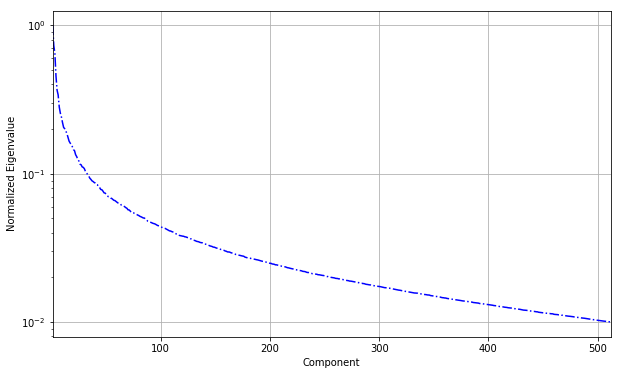

In [22]:
def dimensionality_reduction(eigenvalues, threshold_ratio):
    """ Return the number of dimensions for which the
        eigenvalue is > threshold_ratio * eigenvalue of the first component
    """
    first_eig = eigenvalues[0]
    for i, eig in enumerate(eigenvalues[1:], 2):
        if eig / first_eig < threshold_ratio:
            return i - 1

# Calculate number of dimensions to use for PCA based on ratio of eigenvalues
# Use only components whose eigenvalue is >= 0.01 of that of the first component
Np = dimensionality_reduction(s, 0.01)
display(Markdown("$N_p={}$ components". format(Np)))

# Plot normalized eigenvalues as a function of component number
norm_eigs = [eig/s[0] for eig in s]
_ = plt.figure(figsize=(10,6))
_ = plt.plot(range(1,Np+1), norm_eigs[:Np], 'b-.')
_ = plt.xlim((1,Np))
_ = plt.xlabel("Component")
_ = plt.ylabel("Normalized Eigenvalue")
_ = plt.grid(True)
_ = plt.yscale("log")
plt.show()

In [9]:
def reconstructed_image_matrix(PC, Vt, num_components):
    i = num_components
    return np.dot(PC[:,:i], Vt[:i,:])

def yield_msd_by_dimensionality(X, u, PC, Vt):
    for i in range(1, X.shape[1]):
        Xr = (reconstructed_image_matrix(PC, Vt, i).transpose() + u).transpose()
        yield mean_square_diff(X, Xr)

def plot_MSD_by_dimensionality(X, u, PC, Vt, max_dim):
    """ Compute and plot mean square error of reconstructed
        images vs. number of components
    """
    MSD = []
    for i, msd in enumerate(yield_msd_by_dimensionality(X, u, PC, Vt), 1):
        MSD.append(msd)
        if i == max_dim:
            return MSD

    # Plot mean-square error as a function of the number of PCs
    _ = plt.figure(figsize=(12,6))
    _ = plt.plot(range(1,Np+1), MSD, 'b.-')
    _ = plt.xlim((1,Np))
    _ = plt.xlabel("Number of Principle Components")
    _ = plt.ylabel("Mean Square Error of Reproduced Images")
    _ = plt.grid(True)
    _ = plt.yscale("log")
    plt.show()


In [10]:
# Plot MSD (reconstruction error) for each number of components up to Np
#plot_MSD_by_dimensionality(X, mean_face, PC, Vt, Np)

### Example Reconstruction

1 components


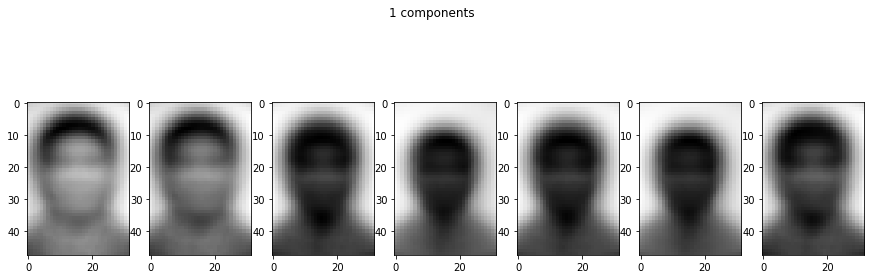

103 components


205 components


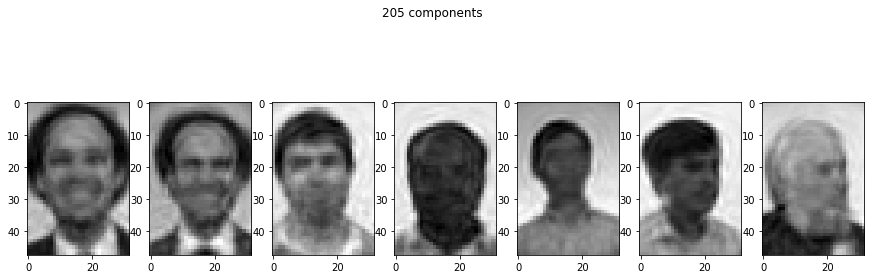

307 components


409 components


511 components


Originals


In [29]:
for components in range(1, Np+1, Np//5):
    print("{} components".format(components))
    reconstructed = reconstructed_image_matrix(PC, Vt, components)
    fig, subs = plt.subplots(1, 7, figsize=(15,5))
    fig.suptitle("{} components".format(components))
    for i, sub in enumerate(subs):
        sub.imshow((reconstructed[:, 30*i] + mean_face).reshape(shape), cmap=cm.gray)
    _= plt.show()
print("Originals")
fig, subs = plt.subplots(1, 7, figsize=(15,5))
fig.suptitle("Originals")
for i, sub in enumerate(subs):
    sub.imshow(X[:, 30*i].reshape(shape), cmap=cm.gray)
_= plt.show()


# Probabilistic Face Recognition

## 2.2.1
The posterior density of a subject label $y$ for a test image $x_\ast$ can be described using Bayes' rule:

$$P(y|x_\ast) = \frac{P(x_\ast |y) P(y)}{P(x_\ast)}$$

It may be helpful to obtain the prior $P(x_\ast)$ by marginalizing over $y$:

$$P(y|x_\ast) = \frac{P(x_\ast |y) P(y)}{\sum_y P(x_\ast |y) P(y)}$$




## 2.2.2
The eigenrepresentation $\phi (x)$ for each $x$ was already computed above during PCA as the matrix $V^T$, each column of which contains the PCA coefficients for one image.  However, our $V^T$ includes coefficients for all the components, not just the first $N_p$, so we need to truncate the excess coefficients of $V^T$ to obtain a smaller matrix $\Phi$ containing only the coefficients for the $N_p$ components:

In [12]:
print(Vt.shape)
Phi = Vt[:Np,:]
print(Phi.shape)
print("First 10 coeffifients for the first image:\n", Phi[:10,0])

(1536, 1603)
(512, 1603)
First 10 coeffifients for the first image:
 [-0.03814252  0.00642828  0.01631366  0.04431135 -0.03179237 -0.00237548
  0.05315288  0.00751348  0.00136216  0.01166539]


## 2.2.3
Next we build a multidimensional Gaussian density function based on the samples for each subject (i.e. determine the mean and variance of each subject's coefficients in the PCA eigenspace).  To be able to do this, we need to compute the mean and variance over the relevant columns of $\Phi$ (i.e. those belonging to each subject).



In [13]:
# collect the (mean, variance) for each face ID in a dictionary
gaussian_parameters_for_face_id = {}

i = 0
for face_id, images in trainset.items():
    j = i + len(images)
    assert all([label[tuple(X[:,j])] == face_id for j in range(i, j)])
    columns_for_face_id = Phi[:,i:j]
    mean = columns_for_face_id.mean(1)
    variance = columns_for_face_id.var(1)
    gaussian_parameters_for_face_id[face_id] = (mean, variance)
    i += len(images)

# for face_id, params in gaussian_parameters_for_face_id.items():
#     # print the mean PCA coefficents for each face
#     print(face_id, params[0])
